In [1]:
%load_ext autoreload
%autoreload 2
from objectives import *
from pebsi.processing.plotting_fxns import *
import pebsi.processing.gridsearch_processing as gsproc
from seasonal_error import *
import cmasher as cmr

In [3]:
# for site in ['Z','T','EC','KPS']: 
#     glacier = 'Wolverine' if site == 'EC' else 'Kahiltna' if site == 'KPS' else 'Gulkana'
#     ds = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/{glacier}_2025_09_22_noqm{site}_0.nc')
#     plot_seasonal_mass_balance(ds)

==========================Z==========================
Weights:
    winter     summer     best
         1          0      ('3.25', '-8.5')
         0          1      ('3.5', '-5')
       0.5        0.5      ('3.5', '-5')
Winter bias: 0.04    Summer bias: -0.66
Winter MAE: 0.37    Summer MAE: 0.79
==========================T==========================
Weights:
    winter     summer     best
         1          0      ('3.5', '-8')
         0          1      ('3.5', '-5')
       0.5        0.5      ('3.5', '-5')
Winter bias: -0.10    Summer bias: -0.00
Winter MAE: 0.17    Summer MAE: 0.16
==========================mean==========================
Weights:
    winter     summer     best
         1          0      ('3.25', '-8.5')
         0          1      ('3.5', '-5')
       0.5        0.5      ('3.5', '-5')
Winter bias: -0.03    Summer bias: -0.33
Winter MAE: 0.27    Summer MAE: 0.47


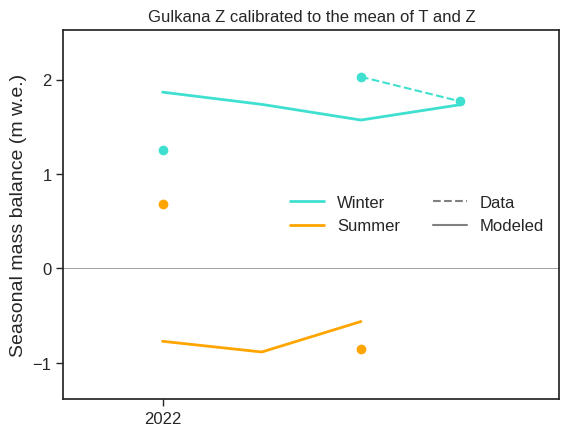

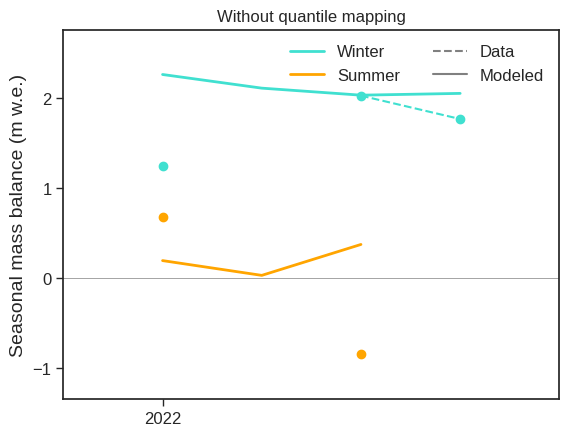

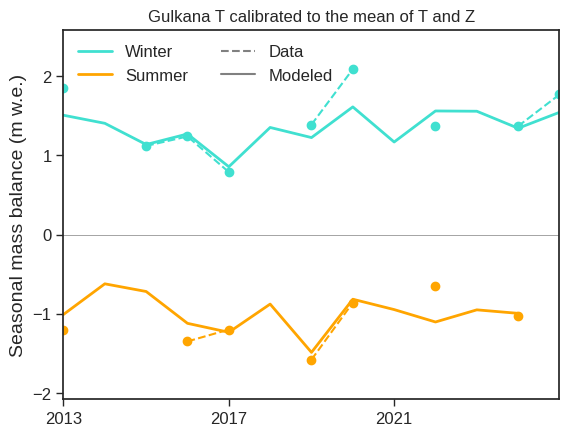

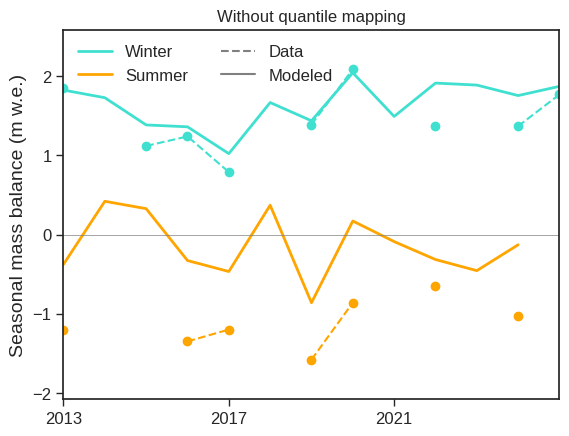

In [5]:
# ===== CALIBRATE ON GULKANA =====
sites = ['Z','T']
gsproc.sitedict['firn'] = sites
result_dict = gsproc.get_result_dict(force_redo=True, parse_runs=['firn'])

# ===== NORMALIZE =====
lim_percentile = 75
all_error = ['winter','summer']
error_lims = {}
for err in all_error:
    error_lims[err] = gsproc.get_percentile(result_dict, err, lim_percentile)
result_dict = gsproc.add_normalized(result_dict, error_lims=error_lims, run_type='firn')

# ===== FIND BEST PARAMETERS =====
best_dict = {}
for site in gsproc.sitedict['firn']+['mean']:
    print(f'=========================={site}==========================')
    best_by = gsproc.get_best_normalized(all_error, result_dict, prints=True, site=site)
    best = best_by[-1]
    best_dict[site] = best
    if site != 'mean':
        ds = gsproc.get_any(result_dict, best[0], best[1], site, run_type='firn')
        # fig, ax = plot_seasonal_mass_balance(ds)
        # ax.set_title(ds.glacier.capitalize() + ' '+site,fontsize=12)
        winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'ME')
        print(f'Winter bias: {winter_error:.2f}    Summer bias: {summer_error:.2f}')
        winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'MAE')
        print(f'Winter MAE: {winter_error:.2f}    Summer MAE: {summer_error:.2f}')
    else:
        winter_error = result_dict[best[0]][best[1]][site]['winter_ME']
        summer_error = result_dict[best[0]][best[1]][site]['summer_ME']
        print(f'Winter bias: {winter_error:.2f}    Summer bias: {summer_error:.2f}')
        winter_error = result_dict[best[0]][best[1]][site]['winter_MAE']
        summer_error = result_dict[best[0]][best[1]][site]['summer_MAE']
        print(f'Winter MAE: {winter_error:.2f}    Summer MAE: {summer_error:.2f}')
        for site in ['Z','T']:
            ds = gsproc.get_any(result_dict, best[0], best[1], site, run_type='firn')
            fig, ax = plot_seasonal_mass_balance(ds)
            ax.set_title(ds.glacier.capitalize() + ' '+site+' calibrated to the mean of T and Z',fontsize=12)
            plt.show()

            glacier = 'Wolverine' if site == 'EC' else 'Kahiltna' if site == 'KPS' else 'Gulkana'
            ds = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/{glacier}_2025_09_22_noqm{site}_0.nc')
            fig, ax = plot_seasonal_mass_balance(ds)
            ax.set_title('Without quantile mapping', fontsize=12)
            plt.show()
        best_gulkana = best


In [6]:
# ds = gsproc.get_any(result_dict, best[0], best[1], 'T', run_type='firn')
# winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'ME')
# print('Before precip adjustment')
# print(f'Winter bias: {winter_error:.2f}    Summer bias: {summer_error:.2f}')
# winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'MAE')
# print(f'Winter MAE: {winter_error:.2f}    Summer MAE: {summer_error:.2f}')
# ds['accum'] *= 1.1
# print('After precip adjustment')
# winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'ME')
# print(f'Winter bias: {winter_error:.2f}    Summer bias: {summer_error:.2f}')
# winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'MAE')
# print(f'Winter MAE: {winter_error:.2f}    Summer MAE: {summer_error:.2f}')
# plot_seasonal_mass_balance(ds)

==========================EC==========================
Weights:
    winter     summer     best
         1          0      ('2', '-8')
         0          1      ('1.5', '-8.5')
       0.5        0.5      ('1.75', '-8.5')
Winter bias: -0.12    Summer bias: 0.03
Winter MAE: 0.39    Summer MAE: 0.38


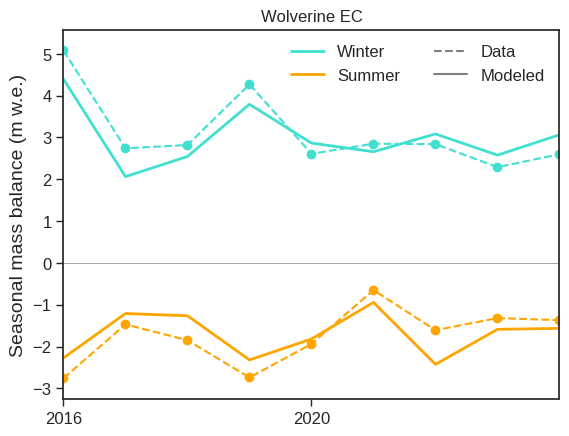

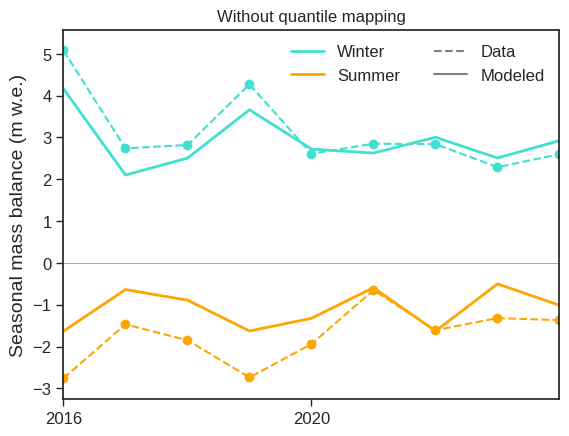

In [7]:
# ===== CALIBRATE ON WOLVERINE =====
gsproc.sitedict['firn'] = ['EC']
result_dict = gsproc.get_result_dict(force_redo=True, parse_runs=['firn'])

# ===== NORMALIZE =====
lim_percentile = 75
all_error = ['winter','summer']
error_lims = {}
for err in all_error:
    error_lims[err] = gsproc.get_percentile(result_dict, err, lim_percentile)
result_dict = gsproc.add_normalized(result_dict, error_lims=error_lims, run_type='firn')

# ===== FIND BEST PARAMETERS =====
best_dict = {}
for site in ['EC']:
    print(f'=========================={site}==========================')
    best_by = gsproc.get_best_normalized(all_error, result_dict, prints=True, site=site)
    best = best_by[-1]
    best_dict[site] = best
    ds = gsproc.get_any(result_dict, best[0], best[1], site, run_type='firn')
    fig, ax = plot_seasonal_mass_balance(ds)
    ax.set_title(ds.glacier.capitalize() + ' '+site,fontsize=12)
    winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'ME')
    print(f'Winter bias: {winter_error:.2f}    Summer bias: {summer_error:.2f}')
    winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'MAE')
    print(f'Winter MAE: {winter_error:.2f}    Summer MAE: {summer_error:.2f}')

    plt.show()
    glacier = 'Wolverine' if site == 'EC' else 'Kahiltna' if site == 'KPS' else 'Gulkana'
    ds = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/{glacier}_2025_09_22_noqm{site}_0.nc')
    fig, ax = plot_seasonal_mass_balance(ds)
    ax.set_title('Without quantile mapping', fontsize=12)
    plt.show()
best_wolverine = best

==========================KPS==========================
Weights:
    winter     summer     best
         1          0      ('2', '-8.5')
         0          1      ('1', '-8')
       0.5        0.5      ('2', '-4.5')
Winter bias: -0.26    Summer bias: -0.18
Winter MAE: 0.58    Summer MAE: 0.98


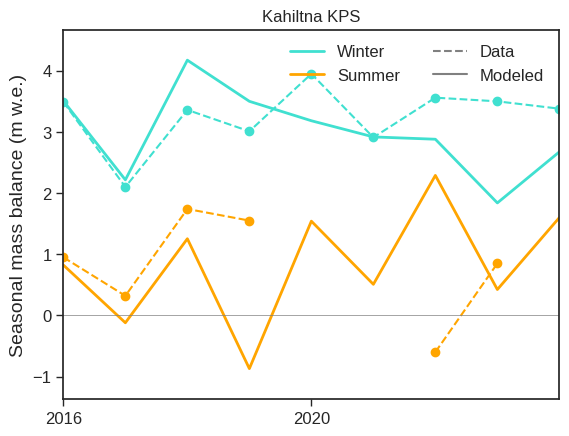

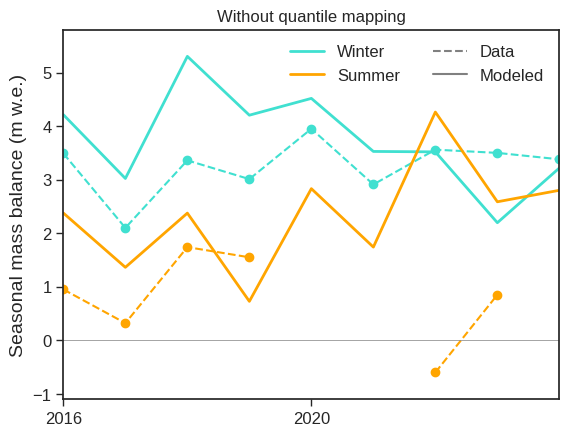

In [8]:
# # ===== CALIBRATE ON KAHILTNA =====
gsproc.sitedict['firn'] = ['KPS']
result_dict = gsproc.get_result_dict(force_redo=True, parse_runs=['firn'])

# ===== NORMALIZE =====
lim_percentile = 75
all_error = ['winter','summer']
error_lims = {}
for err in all_error:
    error_lims[err] = gsproc.get_percentile(result_dict, err, lim_percentile)
result_dict = gsproc.add_normalized(result_dict, error_lims=error_lims, run_type='firn')

# ===== FIND BEST PARAMETERS =====
best_dict = {}
for site in ['KPS']:
    print(f'=========================={site}==========================')
    best_by = gsproc.get_best_normalized(all_error, result_dict, prints=True, site=site)
    best = best_by[-1]
    best_dict[site] = best
    ds = gsproc.get_any(result_dict, best[0], best[1], site, run_type='firn')
    fig, ax = plot_seasonal_mass_balance(ds)
    ax.set_title(ds.glacier.capitalize() + ' '+site,fontsize=12)
    winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'ME')
    print(f'Winter bias: {winter_error:.2f}    Summer bias: {summer_error:.2f}')
    winter_error, summer_error, annual_error = seasonal_mass_balance(ds, 'MAE')
    print(f'Winter MAE: {winter_error:.2f}    Summer MAE: {summer_error:.2f}')

    plt.show()
    glacier = 'Wolverine' if site == 'EC' else 'Kahiltna' if site == 'KPS' else 'Gulkana'
    ds = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/{glacier}_2025_09_22_noqm{site}_0.nc')
    fig, ax = plot_seasonal_mass_balance(ds)
    ax.set_title('Without quantile mapping', fontsize=12)
    plt.show()
best_kahiltna = best

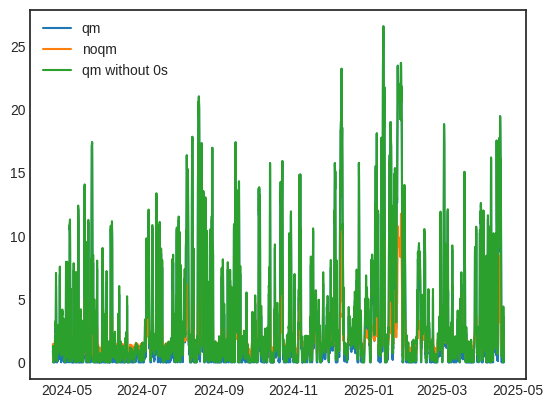

In [29]:
ds_base = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/Kahiltna_2025_09_22_noqmKPS_0.nc')
ds = xr.open_dataset('/trace/group/rounce/cvwilson/Output/test_forcings/09_23_KPS_0/KPS_09_23_wind1_0.nc')
# plt.plot(ds_base.time, ds_base['melt'].cumsum())
# plt.plot(ds.time, ds['melt'].cumsum())

ds_yesqm = xr.open_dataset('../climate_data/yesqm0_climate.nc')['wind']
# ds_yesqm['melt'] = ds_base.sel(time=ds_yesqm.time.values)['melt']
# ds_yesqm = ds_yesqm.where(ds_yesqm['melt'] > 0.0001, drop=True)['wind']
ds_noqm = xr.open_dataset('../climate_data/noqm0_climate.nc')['wind']
# ds_noqm['melt'] = ds.sel(time=ds_noqm.time.values)['melt']
# ds_noqm = ds_noqm.where(ds_noqm['melt'] > 0.0001, drop=True)['wind']
# print(np.sum(ds_yesqm.melt.values[np.where(ds_noqm.wind.values > ds_yesqm.wind.values)[0]])/ len(np.where(ds_noqm.wind.values > ds_yesqm.wind.values)[0]))
# print(np.sum(ds_yesqm.melt.values[np.where(ds_noqm.wind.values < ds_yesqm.wind.values)[0]])/ len(np.where(ds_noqm.wind.values < ds_yesqm.wind.values)[0]))
ds3 = xr.open_dataset('../climate_data/qmwithout0s_0_climate.nc')['wind']

plt.plot(ds_yesqm.time, ds_yesqm.values,label='qm')
plt.plot(ds_noqm.time, ds_noqm.values,label='noqm')
plt.plot(ds3.time, ds3.values,label='qm without 0s')

plt.legend()
plt.show()

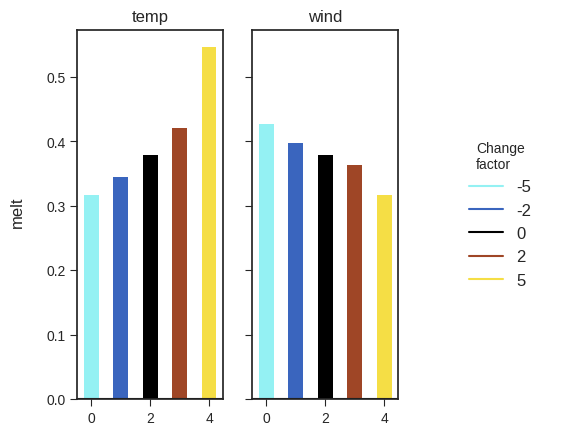

In [5]:
var = 'melt'
ds_base = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/Kahiltna_2025_09_22_noqmKPS_0.nc')
og = ds_base[var].resample(time='YS-APR').sum()
fp = '/trace/group/rounce/cvwilson/Output/test_forcings/09_23_KPS_0/'
vary_vars = ['temp','wind']
vary_by = [0.5, 0.8, 1, 1.2, 2]
fig, axes = plt.subplots(1, len(vary_vars)+1, sharex=True, sharey=True)
cax = axes[-1]
axes = axes[:-1]
cmap = cmr.iceburn
norm = mpl.colors.Normalize(vmin=0, vmax=4)
idx = [0, 1,2,  3, 4]
for ax, vary in zip(axes, vary_vars):
    time = og.time.values
    if vary == 'temp':
        vary_by_use = [-5, -2, 0, 2, 5]
    else:
        vary_by_use = vary_by
    # ax.plot(time, og.values, color=cmap(norm(2)), label='base')
    for i, by in zip(idx, vary_by_use):
        fn = fp + f'KPS_09_23_{vary}{by}_0.nc'
        ds = xr.open_dataset(fn)
        dsvar = ds[var].resample(time='YS-APR').sum()
        # ax.plot(dsvar.time.values, dsvar.values - og.values, label=by, color=cmap(norm(i)))
        mean = np.mean(dsvar[:-1])
        ax.bar(i, mean, width=0.5, color=cmap(norm(i)))
        if vary == vary_vars[0]:
            cax.plot(np.nan, np.nan, label=by, color=cmap(norm(i)))
    # ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
    # ax.set_xticks(pd.date_range(time[0], time[-1], freq='5YS'))
    ax.axhline(0,color='k')
    ax.set_title(vary)
    # ax.yaxis.set_label_position('right')
    ax.tick_params(length=5)
    ax.minorticks_on()
cax.legend(loc='center', fontsize=12, title='Change\nfactor')
cax.axis('off')
fig.supylabel(var)
plt.show()

In [15]:
print(f'Gulkana parameters:     kp {best_gulkana[0]}        lapse_rate {best_gulkana[1]}')
print(f'Wolverine parameters:   kp {best_wolverine[0]}      lapse_rate {best_wolverine[1]}')
print(f'Kahiltna parameters:    kp {best_kahiltna[0]}      lapse_rate {best_kahiltna[1]}')

Gulkana parameters:     kp 3.5        lapse_rate -5
Wolverine parameters:   kp 1.75      lapse_rate -8.5
Kahiltna parameters:    kp 2      lapse_rate -4.5


Use these parameters to perform a long simulation (1980-2025) and create the forcings file below

In [19]:
import xarray as xr
import pandas as pd

# open PEBSI simulation and associated climate (contains rainfall)
for site in ['KPS','EC','Z','T']:
    glacier = 'Gulkana' if site in ['Z','T'] else 'Wolverine' if site == 'EC' else 'Kahiltna'

    ds = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/{glacier}_2025_09_22_long{site}_noqm_0.nc')
    # ds_tp = xr.open_dataset(f'/trace/group/rounce/cvwilson/Output/{glacier}_2025_08_28_long{site}_climate.nc')['tp']
    timeres='1d'
    forcing_fn = f'/trace/group/rounce/cvwilson/Firn/Forcings/{glacier.lower()}{site}_{timeres}_noqm_forcings.csv'

    # clip datasets to a common time
    # clip_time = pd.date_range('1980-04-15 00:00','2025-04-20 00:00',freq='h')
    # ds_tp = ds_tp.sel(time=clip_time)
    # ds = ds.sel(time=clip_time)

    # # changed output so updated runs have vaporsolid mass flux and old runs just have latent heat
    # if 'vaporsolid' in ds.variables:
    # get sublimation from any negative vaporsolid mass fluxes in m w.e.
    ds['vaporsolid'][ds['vaporsolid'] > 0] = 0
    ds['sublim'] = ds['vaporsolid']
    # else:
    #     # get sublimation from latent heat
    #     ds['sublim'] = ds.latent*3600/(2849000 * 1000) # latent (J s-1 m-2) * dt (s) / density_water (kg m-3) / lh_sub (J kg-1) --> m w.e.
    #     ds['sublim'][ds['sublim'] < 0] = 0
    #     ds['sublim'][ds.surftemp.values >= 0] = 0
    #     ds['sublim'] *= -1

    # get rain from total precipitation - accumulation (mask out any erraneous negatives)
    # ds['rain'] = ds_tp - ds['accum']
    # ds['rain'][ds['rain'] < 0] = 0

    # change units of surftemp
    ds['surftemp'] += 273.15

    # get surface density
    layer_thickness = ds.layerheight * 100
    cumulative_depth = layer_thickness.cumsum(dim='layer')
    mask = cumulative_depth <= 50
    weighted_density = ds.layerdensity * layer_thickness.where(mask)
    valid_thickness = layer_thickness.where(mask).sum(dim='layer')
    surfdens = weighted_density.sum(dim='layer') / valid_thickness
    ds['surfdens'] = surfdens

    # resample to the specified resolution with sum (mass balance terms) and mean (surface temp)
    ds_mb = ds[['melt','accum','rainfall','sublim']].resample(time=timeres).sum()
    ds_mb *= 1000   # convert m w.e. to kg m-2
    ds_other = ds[['surftemp','surfdens']].resample(time=timeres).mean()

    # merge datasets and rename
    data_in = xr.merge([ds_mb, ds_other])
    data_in = data_in.rename_vars({'melt':'SMELT', 'rainfall':'RAIN', 'surftemp':'TS', 'accum':'BDOT','sublim':'SUBLIM','surfdens':'RHOS'})

    # store data as a .csv
    df = data_in[['BDOT','RAIN','TS','SMELT','SUBLIM']].to_dataframe()
    print(forcing_fn)
    df.to_csv(forcing_fn)

/trace/group/rounce/cvwilson/Firn/Forcings/kahiltnaKPS_1d_noqm_forcings.csv
/trace/group/rounce/cvwilson/Firn/Forcings/wolverineEC_1d_noqm_forcings.csv
/trace/group/rounce/cvwilson/Firn/Forcings/gulkanaZ_1d_noqm_forcings.csv
/trace/group/rounce/cvwilson/Firn/Forcings/gulkanaT_1d_noqm_forcings.csv


In [ ]:
ds

In [ ]:
# END